In [1]:
import numpy as np
import nibabel
import nilearn
from nilearn.image import resample_to_img
import matplotlib.pyplot as plt
from nilearn import plotting
from nilearn.plotting import show
from nilearn.plotting import plot_roi
from nilearn import image
from nilearn.masking import apply_mask
# get_ipython().magic('matplotlib inline')
import scipy
import matplotlib
import matplotlib.pyplot as plt
from nilearn import image
from nilearn.input_data import NiftiMasker
#from nilearn import plotting
import nibabel
from nilearn.masking import apply_mask
from nilearn.image import load_img
from nilearn.image import new_img_like
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, svm, metrics
from sklearn.linear_model import Ridge
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import KFold
from sklearn.cross_validation import LeaveOneLabelOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.feature_selection import SelectFwe
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy import interp

params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 3),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}
font = {'weight': 'bold',
        'size': 22}
plt.rc('font', **font)
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, f_classif, GenericUnivariateSelect, SelectKBest, chi2
from sklearn.feature_selection import RFE
import os
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
import brainiak
import brainiak.funcalign.srm
import glob

/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/jukebox/pkgs/PYGER/beta/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
projectDir='/jukebox/norman/amennen/prettymouth_fmriprep2/'
DMNmask='/jukebox/norman/amennen/MNI_things/Yeo_JNeurophysiol11_MNI152/Yeo_Network7mask_reoriented_resampledBOLD.nii.gz'
fmriprep_dir=projectDir + '/derivatives/fmriprep'

In [3]:
# load subject numbers
subInd = 0
nsub=38
allnames = []
allgroups = []
groupInfo={}
# skip subjects 039 and 116
with open(projectDir + 'participants.tsv') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        if 'sub' in row[0]:
            # now skip the subjects we don't want to analyze
            allInfo = row[0].split('\t')
            subjName=allInfo[0]
            if subjName != 'sub-039' and subjName != 'sub-116':
                if allInfo[3] == 'paranoia':
                    group = 0
                elif allInfo[3] == 'affair':
                    group = 1
                allnames.append(subjName)
                allgroups.append(group)
                subInd+=1

In [4]:
paranoidSubj = allnames[0:19]
cheatingSubj = allnames[19:]
paranoidLabel = allgroups[0:19]
cheatingLabel = allgroups[19:]
nfolds=19
print(allnames)
segment_score_vector = np.load('segment_score_vector.npy')
beliefs_vector = np.load('beliefs_vector.npy')
emotions_vector = np.load('emotions_vector.npy')
intentions_vector = np.load('intentions_vector.npy')

['sub-088', 'sub-089', 'sub-090', 'sub-091', 'sub-092', 'sub-093', 'sub-094', 'sub-095', 'sub-096', 'sub-097', 'sub-098', 'sub-099', 'sub-100', 'sub-101', 'sub-102', 'sub-103', 'sub-104', 'sub-105', 'sub-106', 'sub-107', 'sub-108', 'sub-109', 'sub-110', 'sub-111', 'sub-068', 'sub-081', 'sub-112', 'sub-053', 'sub-113', 'sub-031', 'sub-114', 'sub-115', 'sub-117', 'sub-118', 'sub-119', 'sub-120', 'sub-121', 'sub-122']


In [6]:
# load results for specific case
ROI = 1
removeAvg = 1
filterType = 1
k1 = 0
k2 = 25
fn = glob.glob('new_bothphases/MEGASTATIONDATA' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg)  + '_filter_' + str(filterType) + '_k1_' + str(k1) + '_k2_' + str(k2)  + '_perm_*.npy')
station_data = np.load(fn[0]) # 58 x 1000 

# load station information
stationsDict = np.load('mega_testing_stations.npy').item()
nStations1 = len(stationsDict)

# get data for 20 and 58
fn2 = glob.glob('new_bothphases/MEGASTATIONDATA2' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg)  + '_filter_' + str(filterType) + '_k1_' + str(k1) + '_k2_' + str(k2)  + '_perm_*.npy')
station_data2 = np.load(fn2[0]) # 58 x 1000
stationsDict2 = np.load('mega_testing_stations2.npy').item()
nStations = len(stationsDict2)

final_station_data = np.zeros((nStations,1000))
use_station_2 = np.array([20,58])
final_station_data[0:nStations1,:] = station_data
final_station_data[use_station_2,:] = station_data2[use_station_2,:]


fn3 = glob.glob('new_bothphases/UPPER_RIGHT' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg)  + '_filter_' + str(filterType) + '_k1_' + str(k1) + '_k2_' + str(k2)  + '_perm_*.npy')
station_data3 = np.load(fn3[0]) # 58 x 1000 

# load station information
stationsDict3 = np.load('stations_upper_right.npy').item()
nStations3 = len(stationsDict3)

(447,)
(1000, 447)
[17 18 19 20 21]
[61 62 63 64 65]
[118 119 120 121]
[144 145 146 147 148 149 150 151 152]
[227 228 229 230]
[282 283 284 285 286 287 288]
[312 313 314]
[338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353]
[377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394
 395 396 397 398]


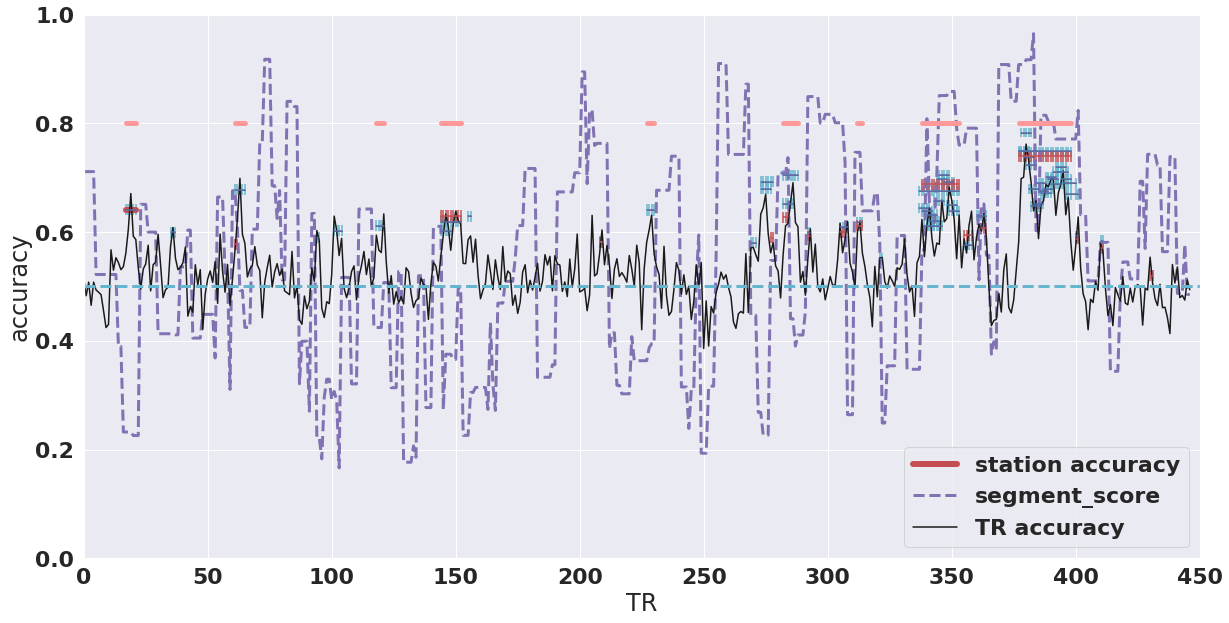

In [26]:
# load TR accuracy to plot in the same figure
classifierType=1
lowhigh=0
filename_data = glob.glob('new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
#print(filename_data)
accuracy = np.load(filename_data[0]).T # this is 450 TRs x 1000 examples
nTR = np.shape(accuracy)[1]
np.mean(accuracy)
x = np.arange(nTR-3)
# changing for this plot--plot actual time points
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)
all_station_err = scipy.stats.sem(final_station_data,axis=1,ddof=1)


print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1
sem_acc = scipy.stats.sem(y)
plt.figure(figsize=(20,10))

# want to include on the figure:
# from station time point 1 - station time point n, accuracy for that station
for st in np.arange(nStations):
    this_station_TRs = np.array(stationsDict2[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(final_station_data[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    if st == 0:
        plt.plot(this_station_TRs-3,this_station_avg, color='r', lw=6, label='station accuracy')
    else:
        plt.plot(this_station_TRs-3,this_station_avg, color='r', lw=1)
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err[st],color='b',ecolor='c')

# plot upper right stations
for st in np.arange(nStations3):
    this_station_TRs = np.array(stationsDict3[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(station_data3[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err[st],color='r', ecolor='r')
    
    
#sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')
plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)

plt.plot(x,np.mean(y,axis=0), color='k', label='TR accuracy')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
#plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0,1])
plt.xlabel('TR')
plt.ylabel('accuracy')
plt.xlim([0,nTR])
chosen = np.load('combined_stations.npy')
chosen = np.load('combined_stations.npy').item()
for st in np.arange(len(chosen)):
    station_TRs = np.array(chosen[st]) - 3
    print(station_TRs)
    n_TRs = len(station_TRs)
    plt.plot(station_TRs,0.8*np.ones((n_TRs,)), lw=5, color='#ff9999', linestyle='-')
plt.legend()

# add: plot lines over chosen stations


In [9]:
chosen = np.load('combined_stations.npy').item()
for st in np.arange(len(chosen)):
    station_TRs = chosen[st]
    print(station_TRs)
    n_TRs = len(station_TRs)
    plt.plot(station_TRs,0.95*np.ones((n_TRs,)))

[20, 21, 22, 23, 24]
[64, 65, 66, 67, 68]
[121, 122, 123, 124]
[147, 148, 149, 150, 151, 152, 153, 154, 155]
[230, 231, 232, 233]
[285, 286, 287, 288, 289, 290, 291]
[315, 316, 317]
[341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356]
[380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401]


In [25]:
good_stations = np.array([0,2,5,7,9,12,15,33,39,56])
for st in np.arange(len(good_stations)):
    print(stationsDict2[good_stations[st]])
print('*****')
print(stationsDict3)

[20, 21, 22, 23, 24]
[64, 65, 66, 67, 68]
[121, 122, 123, 124]
[158, 159]
[230, 231, 232, 233]
[285, 286, 287, 288, 289, 290, 291]
[315, 316, 317]
[348, 349, 350, 351, 352]
[381, 382, 383, 384, 385]
[398, 399, 400, 401, 403]
*****
{0: [64, 65], 1: [147, 148, 149, 150, 151, 152, 153, 154, 155], 2: [211, 212], 3: [280, 281], 4: [285, 286, 287], 5: [295, 296], 6: [308, 309, 310], 7: [315, 316, 317], 8: [341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356], 9: [358, 359, 360, 361], 10: [365, 366, 367], 11: [380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401], 12: [403, 404], 13: [413, 414], 14: [433, 434]}


In [27]:
# new as of 3/20 make new station dictionary combining upper right and mega search
combined_station_dict = {}
combined_station_dict[0] = [20, 21, 22, 23, 24]
combined_station_dict[1] = [64, 65, 66, 67, 68]
combined_station_dict[2] = [121, 122, 123, 124]
combined_station_dict[3] = [147, 148, 149, 150, 151, 152, 153, 154, 155]
combined_station_dict[4] = [230, 231, 232, 233]
combined_station_dict[5] = [285, 286, 287, 288, 289, 290, 291]
combined_station_dict[6] = [315, 316, 317]
combined_station_dict[7] = [341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356]
combined_station_dict[8] = [380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401]
#combined_station_dict[9] = [413, 414]
np.save('combined_stations.npy', combined_station_dict)

REAL correlation is 0.5044
REAL p value is 0.0000


Text(0,0.5,'Zscored segment difference')

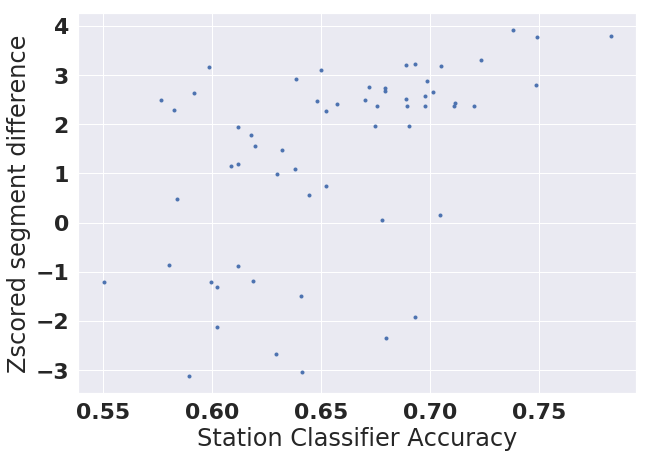

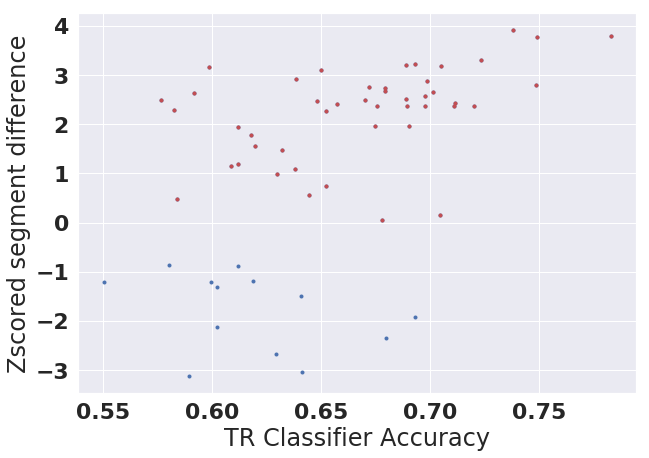

In [27]:
# plot segment score across time points of station
segment_station_score = np.zeros((nStations,))
station_classification = np.zeros((nStations,))

for st in np.arange(nStations):
    this_station_TRs = np.array(stationsDict2[st]) - 3 # to align to ratings
    segment_station_score[st] = np.mean(segment_score_vector[this_station_TRs])
    station_classification[st] = np.mean(final_station_data[st,:])

plt.figure(figsize=(10,7))
plt.plot(station_classification,segment_station_score, '.')
plt.xlabel('Station Classifier Accuracy')
plt.ylabel('Zscored segment difference')

[corr,p] = scipy.stats.pearsonr(station_classification,segment_station_score)
print('REAL correlation is %4.4f' % corr)
print('REAL p value is %4.4f' % p)


# now take upper right part
TR_vector = np.arange(len(segment_station_score))
large_diff = segment_station_score > 0
large_acc = station_classification > 0.55
upper_right = np.intersect1d(TR_vector[large_diff],TR_vector[large_acc])

plt.figure(figsize=(10,7))
plt.plot(station_classification,segment_station_score, '.')
plt.plot(station_classification[upper_right],segment_station_score[upper_right], 'r.')
plt.xlabel('TR Classifier Accuracy')
plt.ylabel('Zscored segment difference')

[ 2  8 12 13 14 15 17 18 19 20 21 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58]


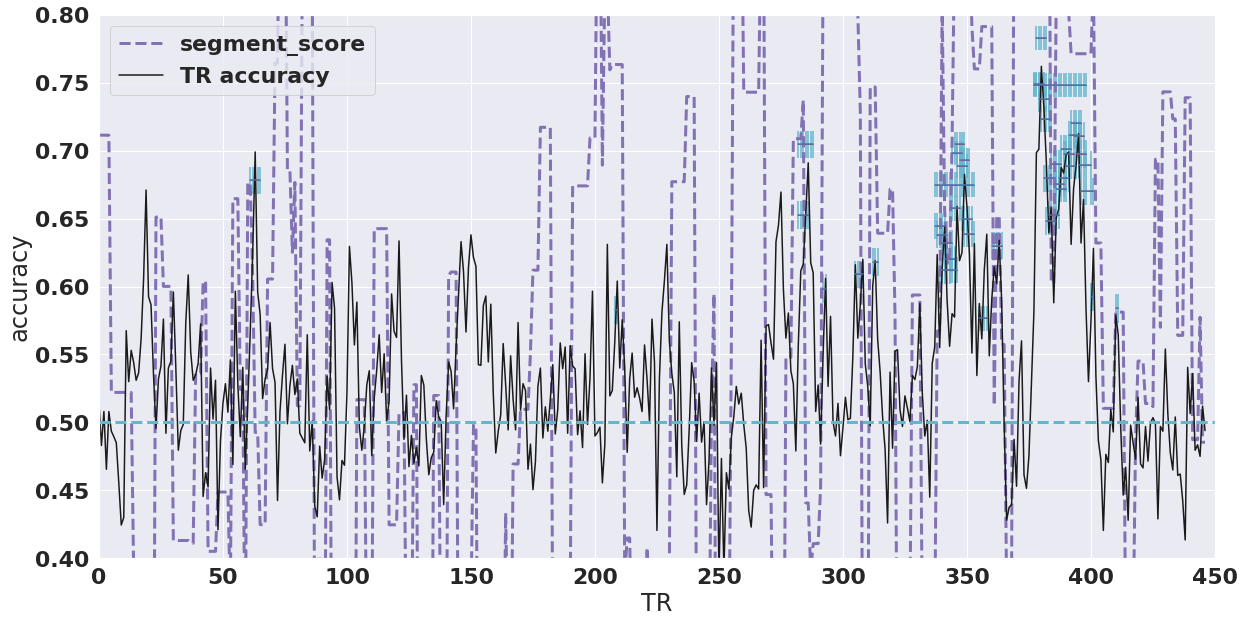

In [38]:
# now redo plot but only upper right stations

plt.figure(figsize=(20,10))

# want to include on the figure:
# from station time point 1 - station time point n, accuracy for that station
for i in np.arange(len(upper_right)):
    st = upper_right[i]
    this_station_TRs = np.array(stationsDict2[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(final_station_data[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    if st == 0:
        plt.plot(this_station_TRs-3,this_station_avg, color='r', lw=6, label='station accuracy')
    else:
        plt.plot(this_station_TRs-3,this_station_avg, color='r', lw=1)
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err[st],ecolor='c')
    
#sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')
plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)

plt.plot(x,np.mean(y,axis=0), color='k', label='TR accuracy')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
#plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0.4,.8])
plt.xlabel('TR')
plt.ylabel('accuracy')
plt.xlim([0,nTR])
plt.legend()

print(upper_right)

[380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397
 398 399 400 401]
[413 414]


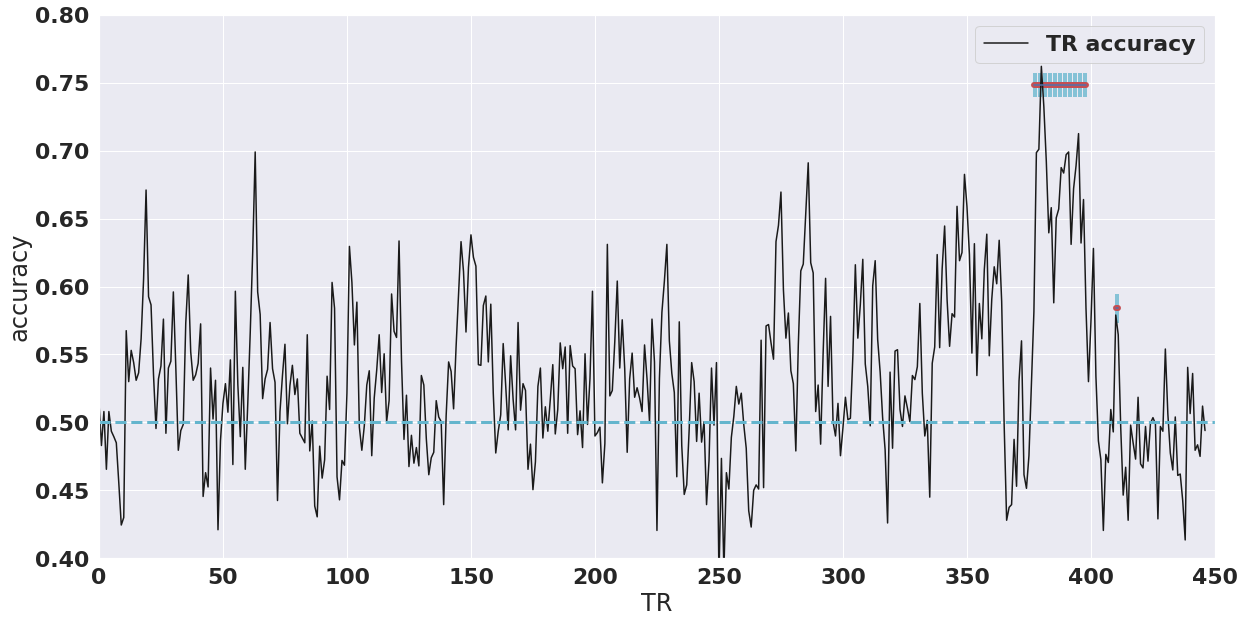

In [68]:
upper_right
plot = np.array([20,21])
ntest = len(plot)
plt.figure(figsize=(20,10))
for i in np.arange(ntest):
    st = plot[i]
    this_station_TRs = np.array(stationsDict2[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(final_station_data[st,:])*np.ones((n_station_TRs,))
    print(this_station_TRs)
    # plot with error bars
    # put only one label
    if st == 0:
        plt.plot(this_station_TRs-3,this_station_avg, color='r', lw=6, label='station accuracy')
    else:
        plt.plot(this_station_TRs-3,this_station_avg, color='r', lw=6)
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err[st],ecolor='c')

#plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)

plt.plot(x,np.mean(y,axis=0), color='k', label='TR accuracy')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
#plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0.4,.8])
plt.xlabel('TR')
plt.ylabel('accuracy')
plt.xlim([0,nTR])
plt.legend()

In [7]:
# from 3/20: repeat with only upper right stations
ROI = 1
removeAvg = 1
filterType = 1
k1 = 0
k2 = 25
fn = glob.glob('new_bothphases/UPPER_RIGHT' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg)  + '_filter_' + str(filterType) + '_k1_' + str(k1) + '_k2_' + str(k2)  + '_perm_*.npy')
station_data = np.load(fn[0]) # 58 x 1000 

# load station information
stationsDict = np.load('stations_upper_right.npy').item()
nStations = len(stationsDict)

final_station_data = station_data


(447,)
(1000, 447)


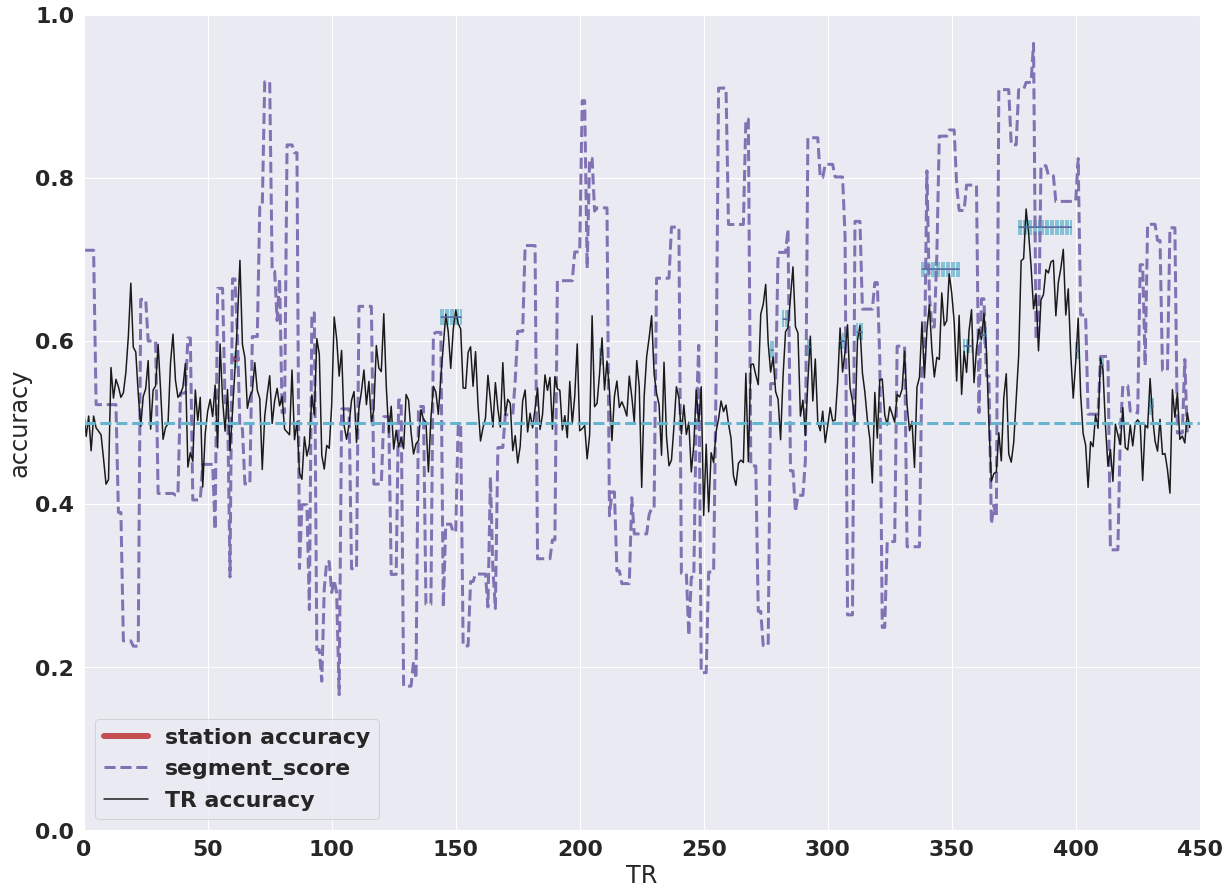

In [9]:
# load TR accuracy to plot in the same figure
classifierType=1
lowhigh=0
filename_data = glob.glob('new_bothphases/ARRAYDATA_BS_' + '_ROI_' + str(ROI) + '_AVGREMOVE_' + str(removeAvg) +  '_classifierType_' + str(classifierType) + '_filter_' + str(filterType) + '_lowhigh_' + str(lowhigh) + '_k1_' + str(k1) + '_k2_' + str(k2) + '_perm_*.npy')
#print(filename_data)
accuracy = np.load(filename_data[0]).T # this is 450 TRs x 1000 examples
nTR = np.shape(accuracy)[1]
np.mean(accuracy)
x = np.arange(nTR-3)
# changing for this plot--plot actual time points
y = accuracy[:,3:]
mean_acc = np.mean(y,axis=0)
all_station_err = scipy.stats.sem(final_station_data,axis=1,ddof=1)


print(np.shape(x))
print(np.shape(y))
# make into dataframe: TR, accuracy
n_iter=1000
TR_vec = np.tile(x,n_iter)
data = y.flatten()

iter_number = np.repeat(np.arange(n_iter),nTR-3)
matrix = np.concatenate((TR_vec[:,np.newaxis],data[:,np.newaxis],iter_number[:,np.newaxis]),axis=1)
df = pd.DataFrame(data=matrix, columns = ['TR', 'accuracy','iter'])

sns.set(style="white")
sns.set(font_scale=2)
err_band = {}
err_band['alpha'] = 1
sem_acc = scipy.stats.sem(y)
plt.figure(figsize=(20,15))

# want to include on the figure:
# from station time point 1 - station time point n, accuracy for that station
for st in np.arange(nStations):
    this_station_TRs = np.array(stationsDict[st])
    n_station_TRs = len(this_station_TRs)
    this_station_avg = np.mean(final_station_data[st,:])*np.ones((n_station_TRs,))
    # plot with error bars
    # put only one label
    if st == 0:
        plt.plot(this_station_TRs-3,this_station_avg, color='r', lw=6, label='station accuracy')
    else:
        plt.plot(this_station_TRs-3,this_station_avg, color='r', lw=1)
    plt.errorbar(this_station_TRs-3,this_station_avg,yerr=all_station_err[st],ecolor='c')
    
#sns.lineplot(x="TR",y="accuracy",color='b',data=df,ci=95,err_kws=err_band,label='real dist')
plt.plot(segment_score_vector[0:-3]/10 + np.mean(y), '--', color='m', label='segment_score',linewidth=3)

plt.plot(x,np.mean(y,axis=0), color='k', label='TR accuracy')
#plt.plot(x,np.mean(y,axis=0), color='k', label='accuracy')
#plt.plot([0 ,500], [.6, .6], 'r--', lw=6)
plt.plot([0 ,500], [.5, .5], 'c--', lw=3)
plt.ylim([0,1])
plt.xlabel('TR')
plt.ylabel('accuracy')
plt.xlim([0,nTR])
plt.legend()

In [8]:
# this is where I get the winning stations and then just input the station indicves into train_classifier_for_RT_stations
st = 58
print(np.mean(final_station_data[st,:]))
print(stationsDict2[st])
good_stations_checked = np.array([0,2,5,7,9,12,15,17,20,21])

good_stations = np.array([0,2,5,7,9,12,15,33,39,56])
len(good_stations)

0.592
[403, 404]


10

In [9]:
st = 56
print(np.mean(final_station_data[st,:]))
print(stationsDict2[st])

0.6895
[398, 399, 400, 401, 403]


In [15]:
print(np.mean(final_station_data,axis=1))

[0.6415 0.5995 0.678  0.5895 0.6025 0.612  0.619  0.6295 0.5825 0.641
 0.5805 0.693  0.7045 0.5985 0.609  0.618  0.5505 0.675  0.5765 0.63
 0.7485 0.584  0.6025 0.68   0.6525 0.6445 0.638  0.612  0.632  0.62
 0.612  0.6575 0.6985 0.705  0.689  0.693  0.65   0.6385 0.749  0.783
 0.738  0.7235 0.6795 0.648  0.6525 0.6905 0.6755 0.672  0.6795 0.7015
 0.6975 0.689  0.7115 0.72   0.711  0.6975 0.6895 0.67   0.592 ]


Text(0,0.5,'accuracy')

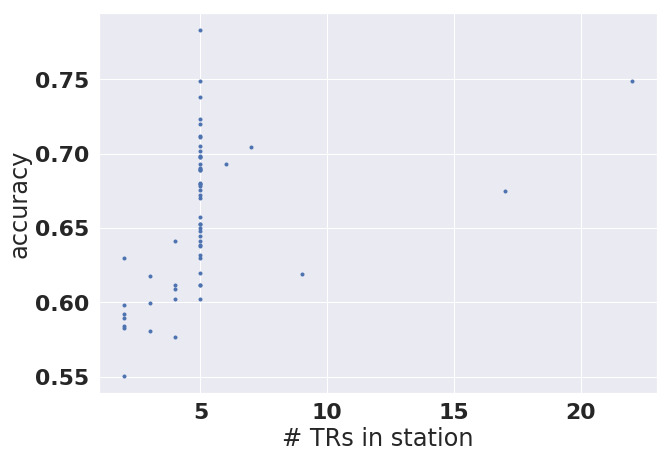

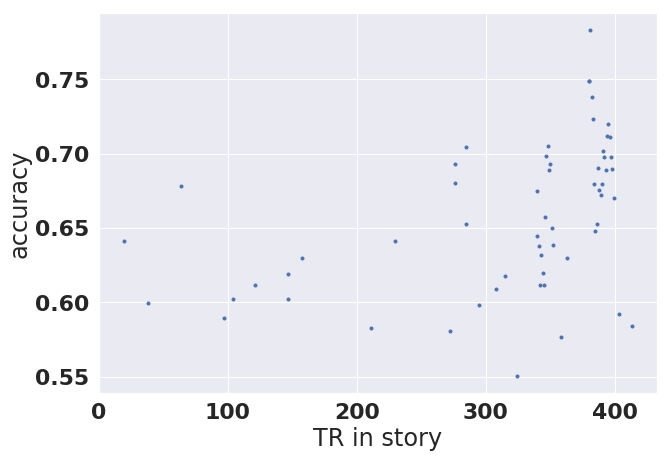

In [23]:
# relationship between nTRs and accuracy
len_stations = np.zeros((nStations,))
first_tr = np.zeros((nStations,))
for st in np.arange(nStations):
    this_station_TRs = np.array(stationsDict2[st])
    len_stations[st] = len(this_station_TRs)
    first_tr[st] = this_station_TRs[0]
all_accuracy_station = np.mean(final_station_data, axis=1)
plt.figure(figsize=(10,7))
plt.plot(len_stations,all_accuracy_station, '.')
plt.xlabel('# TRs in station')
plt.ylabel('accuracy')
plt.figure(figsize=(10,7))
plt.plot(first_tr,all_accuracy_station, '.')
plt.xlabel('TR in story')
plt.ylabel('accuracy')